# Adadelta
:label:`sec_adadelta`


Adadelta是AdaGrad的另一种变体（ :numref:`sec_adagrad`），
主要区别在于前者减少了学习率适应坐标的数量。
此外，广义上Adadelta被称为没有学习率，因为它使用变化量本身作为未来变化的校准。
Adadelta算法是在 :cite:`Zeiler.2012`中提出的。

## Adadelta算法

简而言之，Adadelta使用两个状态变量，$\mathbf{s}_t$用于存储梯度二阶导数的泄露平均值，$\Delta\mathbf{x}_t$用于存储模型本身中参数变化二阶导数的泄露平均值。请注意，为了与其他出版物和实现的兼容性，我们使用作者的原始符号和命名（没有其它真正理由让大家使用不同的希腊变量来表示在动量法、AdaGrad、RMSProp和Adadelta中用于相同用途的参数）。

以下是Adadelta的技术细节。鉴于参数du jour是$\rho$，我们获得了与 :numref:`sec_rmsprop`类似的以下泄漏更新：

$$\begin{aligned}
    \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2.
\end{aligned}$$

与 :numref:`sec_rmsprop`的区别在于，我们使用重新缩放的梯度$\mathbf{g}_t'$执行更新，即

$$\begin{aligned}
    \mathbf{x}_t  & = \mathbf{x}_{t-1} - \mathbf{g}_t'. \\
\end{aligned}$$

那么，调整后的梯度$\mathbf{g}_t'$是什么？我们可以按如下方式计算它：

$$\begin{aligned}
    \mathbf{g}_t' & = \frac{\sqrt{\Delta\mathbf{x}_{t-1} + \epsilon}}{\sqrt{{\mathbf{s}_t + \epsilon}}} \odot \mathbf{g}_t, \\
\end{aligned}$$

其中$\Delta \mathbf{x}_{t-1}$是重新缩放梯度的平方$\mathbf{g}_t'$的泄漏平均值。我们将$\Delta \mathbf{x}_{0}$初始化为$0$，然后在每个步骤中使用$\mathbf{g}_t'$更新它，即

$$\begin{aligned}
    \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) {\mathbf{g}_t'}^2,
\end{aligned}$$

和$\epsilon$（例如$10^{-5}$这样的小值）是为了保持数字稳定性而加入的。

## 代码实现

Adadelta需要为每个变量维护两个状态变量，即$\mathbf{s}_t$和$\Delta\mathbf{x}_t$。这将产生以下实现。


In [1]:
%matplotlib inline
import torch
# from d2l import torch as d2l


def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-placeupdatesvia[:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

对于每次参数更新，选择$\rho = 0.9$相当于10个半衰期。由此我们得到：


In [2]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

def download_file(url, filename):
    """下载文件"""
    import urllib.request
    import os
    
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filename)
    else:
        print(f"{filename} already exists.")
    return filename

def load_array(data_arrays, batch_size, is_train=True):
    """构建PyTorch数据迭代器"""
    dataset = TensorDataset(*data_arrays)
    return DataLoader(dataset, batch_size, shuffle=is_train)

# 数据集信息
DATA_HUB = {}
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['airfoil'] = (DATA_URL + 'airfoil_self_noise.dat',
                       '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def get_data_ch11(batch_size=10, n=1500):
    """
    获取空气动力学数据集
    
    参数:
    - batch_size: 批量大小
    - n: 使用的样本数量
    
    返回:
    - data_iter: 数据迭代器
    - feature_dim: 特征维度
    """
    # 下载数据
    url, sha1_hash = DATA_HUB['airfoil']
    filename = 'airfoil_self_noise.dat'
    download_file(url, filename)
    
    # 加载数据
    data = np.genfromtxt(filename, dtype=np.float32, delimiter='\t')
    
    # 数据标准化：移除均值并缩放方差为1
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    
    # 取前n个样本，特征为前几列，标签为最后一列
    features = torch.from_numpy(data[:n, :-1])
    labels = torch.from_numpy(data[:n, -1])
    
    # 创建数据加载器
    data_iter = load_array((features, labels), batch_size, is_train=True)
    
    # 返回数据迭代器和特征维度
    return data_iter, data.shape[1]-1

In [3]:
from IPython import display
import torch

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        
        # 替换 d2l.use_svg_display()
        import matplotlib.pyplot as plt
        plt.rcParams['figure.figsize'] = figsize
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 替换 d2l.set_axes，使用 lambda 函数直接配置参数
        self.config_axes = lambda: self._set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def _set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置坐标轴标签、范围和比例"""
        import matplotlib.pyplot as plt
        # 设置坐标轴标签
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        # 设置坐标轴范围
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        # 设置坐标轴比例
        if xscale:
            ax.set_xscale(xscale)
        if yscale:
            ax.set_yscale(yscale)
        # 设置图例
        if legend:
            ax.legend(legend)
        # 添加网格
        ax.grid(True)

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

import time
import numpy as np
import torch

class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # 初始化模型
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: linreg(X, w, b), squared_loss
    # 训练模型
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

loss: 0.243, 0.006 sec/epoch


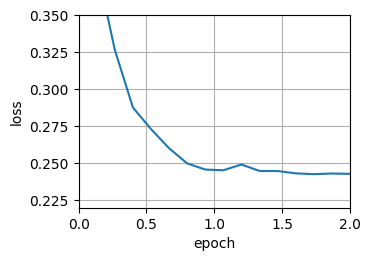

In [4]:
data_iter, feature_dim = get_data_ch11(batch_size=10)
train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

为了简洁实现，我们只需使用高级API中的Adadelta算法。


In [5]:
from torch import nn
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # MSELoss计算平方误差时不带系数1/2
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

loss: 0.242, 0.007 sec/epoch


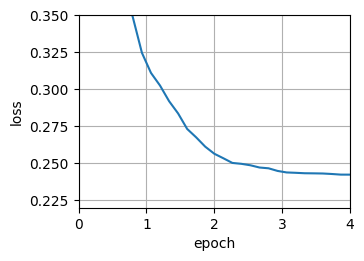

In [6]:
trainer = torch.optim.Adadelta
train_concise_ch11(trainer, {'rho': 0.9}, data_iter)

## 小结

* Adadelta没有学习率参数。相反，它使用参数本身的变化率来调整学习率。
* Adadelta需要两个状态变量来存储梯度的二阶导数和参数的变化。
* Adadelta使用泄漏的平均值来保持对适当统计数据的运行估计。

## 练习

1. 调整$\rho$的值，会发生什么？
1. 展示如何在不使用$\mathbf{g}_t'$的情况下实现算法。为什么这是个好主意？
1. Adadelta真的是学习率为0吗？能找到Adadelta无法解决的优化问题吗？
1. 将Adadelta的收敛行为与AdaGrad和RMSProp进行比较。


[Discussions](https://discuss.d2l.ai/t/5772)
